# Convolutional Neural Networks : Step by Step
- We will implement convolutional (CONV) and pooling (POOL) layers in numpy, including forward propagation and backpropagation.
### Notations
- Supescript [l] denotes an object of the lth layer. Example : a[4] is the 4th layer activation. W[5] and b[5] are the 5th layer parameters.
- Supercript (i) denotes an object from the ith example. Example : x(i) is the ith training example input.
- subscript i denotes ith entry of a vector. Example : a[l]i denotes the ith entry of the activations in layer l.
- nH, nW and nC denote respectively the height, width and number of channels of a given layer.

# 1. Packages
- numpy is the fundamental package for scientific computing with Python.
- matplotlib is a libary to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. 

In [4]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# 2. Outline of the Assignment
- We will be implementing the building blocks of a convolutional neural network. Each function we will implement will have detailed instructions to walk us through the stpes:
    - Convolution functions, including :
        - Zero padding
        - Convolve window
        - Convolution forward
        - Convolution backward
    - Pooling functions, including :
        - Pooling forward
        - Create mask
        - Distribute value
        - Pooling backward
- We will use the TensorFlow equivalents of the functions to build the following model :
    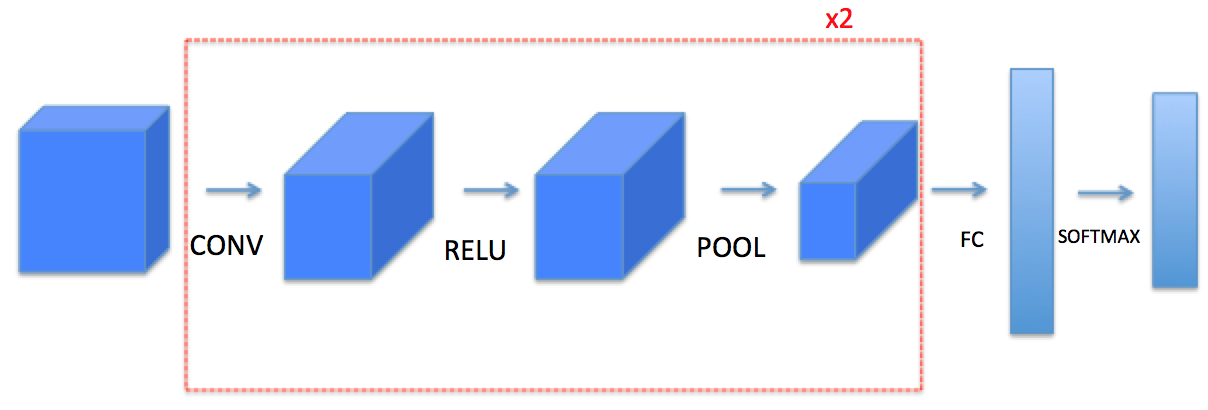
- Note : For every forward function, there is a corresponding backward equivalent. Hence, at every step of our forward module we will store some parameters in a cache. These parameters are used to compute gradients during backwardpropagation.

# 3. Convolutional Neural Network
- A convolutional layer transforms an input volume into an output volume of different size.
    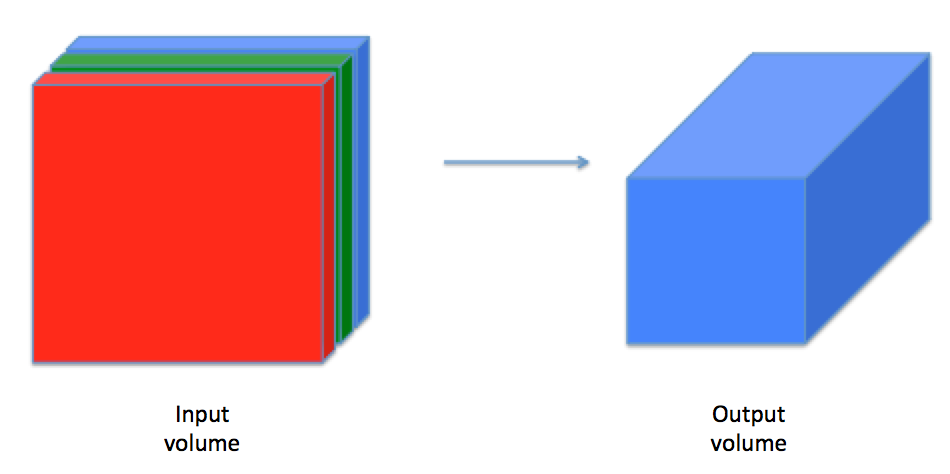
- We will build every step of the convolution layer. We will first implemenmt 2 helper functions : One for zeor padding and the other for computing the convolution function itself.

## 3.1 Zero Padding
- Zero padding adds zeros arounf the border of an image : 
    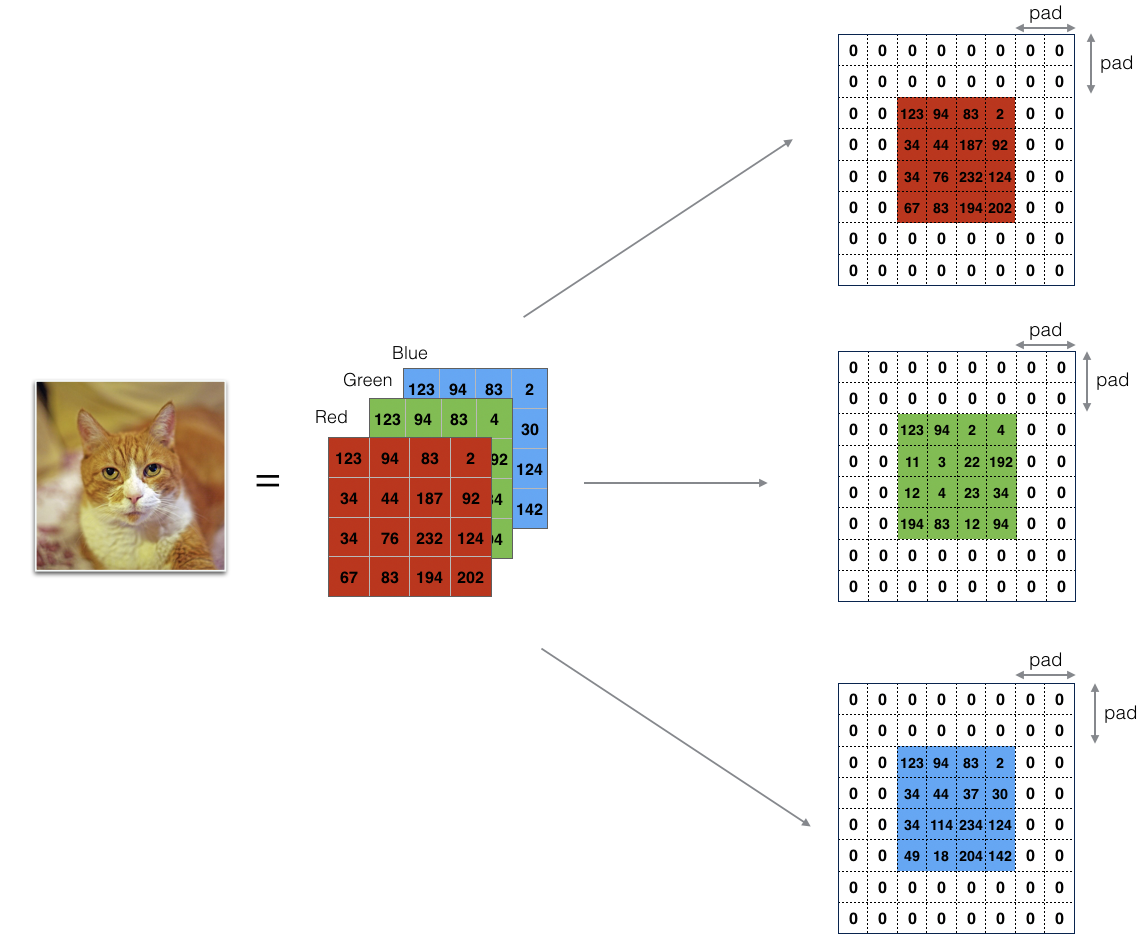
- The main benefits of padding are : 
    - It allows us to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for buidling deeper networks, since otherwise the heigh/width would shrink as we go to deeper layers. An important special case is the 'same convolution', in which the height/width is exactly preserved after one layer.
    - It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels at the edges of an image.

- Implememt the function, which pads all the images of a batch of example X with zeros. Use np.pad 

In [5]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
    as illustrated in Figure 1.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2 * pad, n_W + 2 * pad, n_C)
    """
   
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad),(0,0)), 'constant', constant_values = 0)

    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 9, 9, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


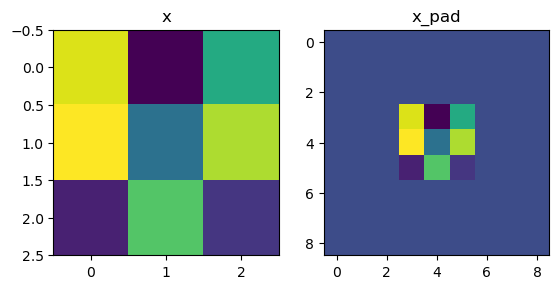

In [6]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 3)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1, 1])
print ("x_pad[1,1] =\n", x_pad[1, 1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0, :, :, 0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0, :, :, 0])

## 3.2 Single Step of Convolution
- Implement a single step of convolution, in which we apply the filter to a single position of the input. This will be used to build a convolutional unit, which :
    - Takes an input volume
    - Applied a filter at every position of the input
    - Outputs another volume (usually of different size)
      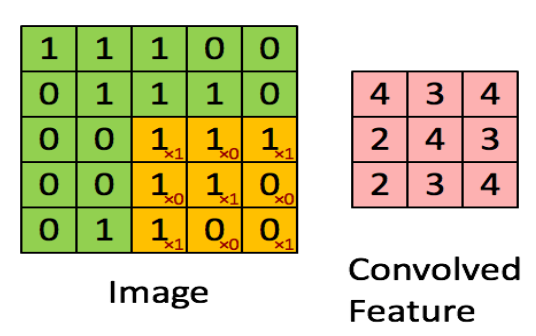
- In a computer vision application, each value in the matrix on the left corresponds to a single pixel value. We convolve a 3x3 filter with the image by multiplying its values element-wise with the original matrix, then summing them up and adding a bias. 
- We will implement a single step of convolution, correponding to applying a filter to just one of the positions to get a single real-valued output.

In [7]:
def conv_single_step(a_slice_prev, W, b):
    '''
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation of the previous layer.
    
    Arguments:
    a_slice_prev : Slice of input data of shape (f, d, n_C_prev)
    W : Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b : Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns :
    z : A scalar value, the result of convolving the slicing window (W, b) on a slice x of input data
    '''
    # Element-wise product between a_slice_prev and W. Do not add the bias yet.
    s = np.multiply(a_slice_prev,W)
    # Sum over all entries of the volume s.
    Z = np.sum(s)
    # Add bias b to Z. Cast b to a float() so that Z results in a scalar value.
    Z = Z+ float(b)

    return Z

In [8]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


C:\Users\surya\AppData\Local\Temp\ipykernel_7244\3859041495.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z+ float(b)


## 3.3 Convolutional Neural Networks - Forward Pass
- In the forward pass, we will take many filters and convolve them on the input. Each 'convolution' gives us a 2D matrix output. We will then stack these outputs to get a 3D volume.
- 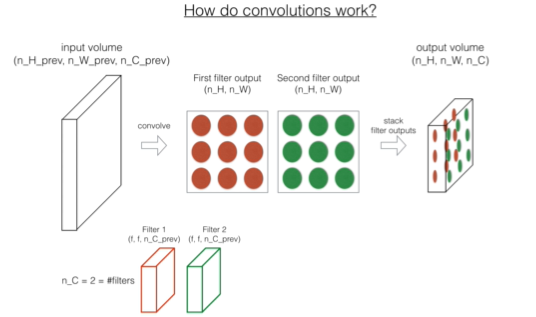
- Implement the function to convolve the filters W on an input activation A_prev. The function takes the following inputs:
    - A_prev, the activations output by the previous layer (for a batch for m inputs)
    - Weights are denoted by W. The filter window size if fxf.
    - The bias vector is b, where each filter has its own (single) bias.
- We also have access to the hyperparameters dictionary, which contains the stride and the padding.
- The formulas relating the output shape of the convolution to the input shape are :
    - 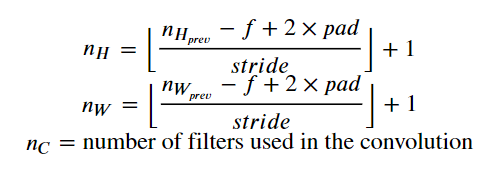

In [9]:
# GRADED FUNCTION: conv_forward

def conv_forward(A_prev, W, b, hparameters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, 
        numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    
    # Retrieve dimensions from A_prev's shape  
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve dimensions from W's shape
    (f, f, n_C_prev, n_C) = W.shape
    
    # Retrieve information from "hparameters"
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Compute the dimensions of the CONV output volume using the formula given above. 
    n_H = int((n_H_prev - f + 2 * pad)/stride)+1
    n_W = int((n_W_prev - f + 2 *pad)/stride)+1
    
    # Initialize the output volume Z with zeros. 
    Z = np.zeros((m, n_H, n_W, n_C))
    
    # Create A_prev_pad by padding A_prev
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):               # loop over the batch of training examples
        a_prev_pad = A_prev_pad[i]    # Select ith training example's padded activation
        for h in range(n_H):           # loop over vertical axis of the output volume
            # Find the vertical start and end of the current "slice"
            vert_start = h*stride
            vert_end = vert_start + f
            
            for w in range(n_W):       # loop over horizontal axis of the output volume
                # Find the horizontal start and end of the current "slice"
                horiz_start = w*stride
                horiz_end = horiz_start + f
                
                for c in range(n_C):   # loop over channels (= #filters) of the output volume
                                        
                    # Use the corners to define the (3D) slice of a_prev_pad (See Hint above the cell). (≈1 line)
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]
                    
                    # Convolve the (3D) slice with the correct filter W and bias b, to get back one output neuron. (≈3 line)
                    weights = W[...,c]
                    biases = b[...,c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
    
    # Save information in "cache" for the backprop
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [13]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 7, 4)
W = np.random.randn(3, 3, 4, 8)
b = np.random.randn(1, 1, 1, 8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
z_mean = np.mean(Z)
z_0_2_1 = Z[0, 2, 1]
cache_0_1_2_3 = cache_conv[0][1][2][3]
print("Z's mean =\n", z_mean)
print("Z[0,2,1] =\n", z_0_2_1)
print("cache_conv[0][1][2][3] =\n", cache_0_1_2_3)

Z's mean =
 0.5511276474566768
Z[0,2,1] =
 [-2.17796037  8.07171329 -0.5772704   3.36286738  4.48113645 -2.89198428
 10.99288867  3.03171932]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


C:\Users\surya\AppData\Local\Temp\ipykernel_7244\3859041495.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z = Z+ float(b)


# 4. Pooling Layer
- The pooling (POOL) layer reduces the height and width of the input. It helps reduce computation, as well as helps make feature detectors more invariant to its position in the input. The 2 types of pooling layers are : 
    - Max-pooling layer : Slides an (f,f) window over the input and stores the max value of the widnow in the output.
    - Average-pooling layer : Slides an (f, f) window over the input and stores the average value of the window in the ouput.
    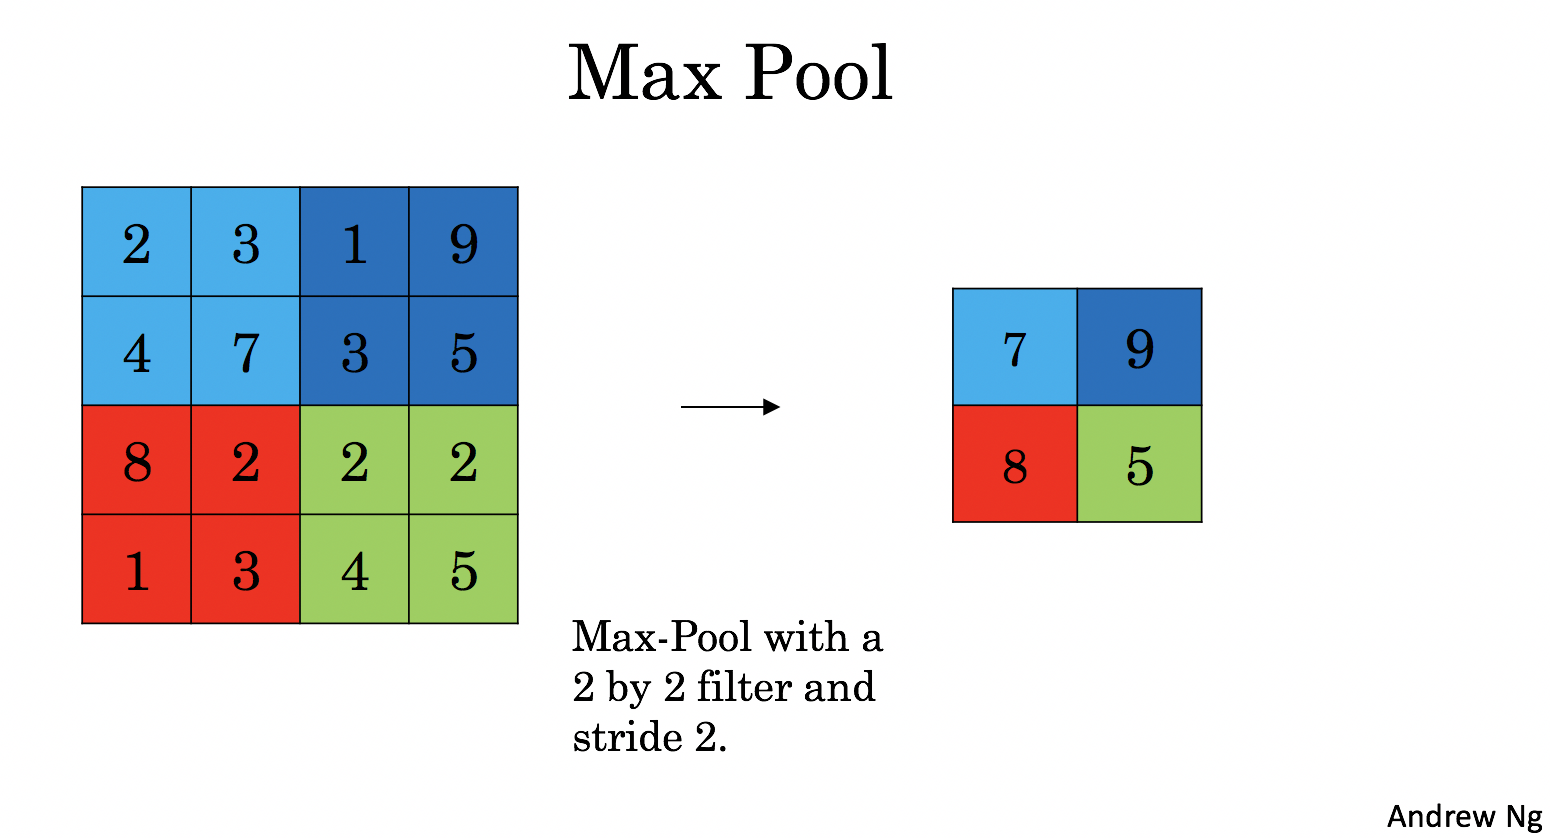
    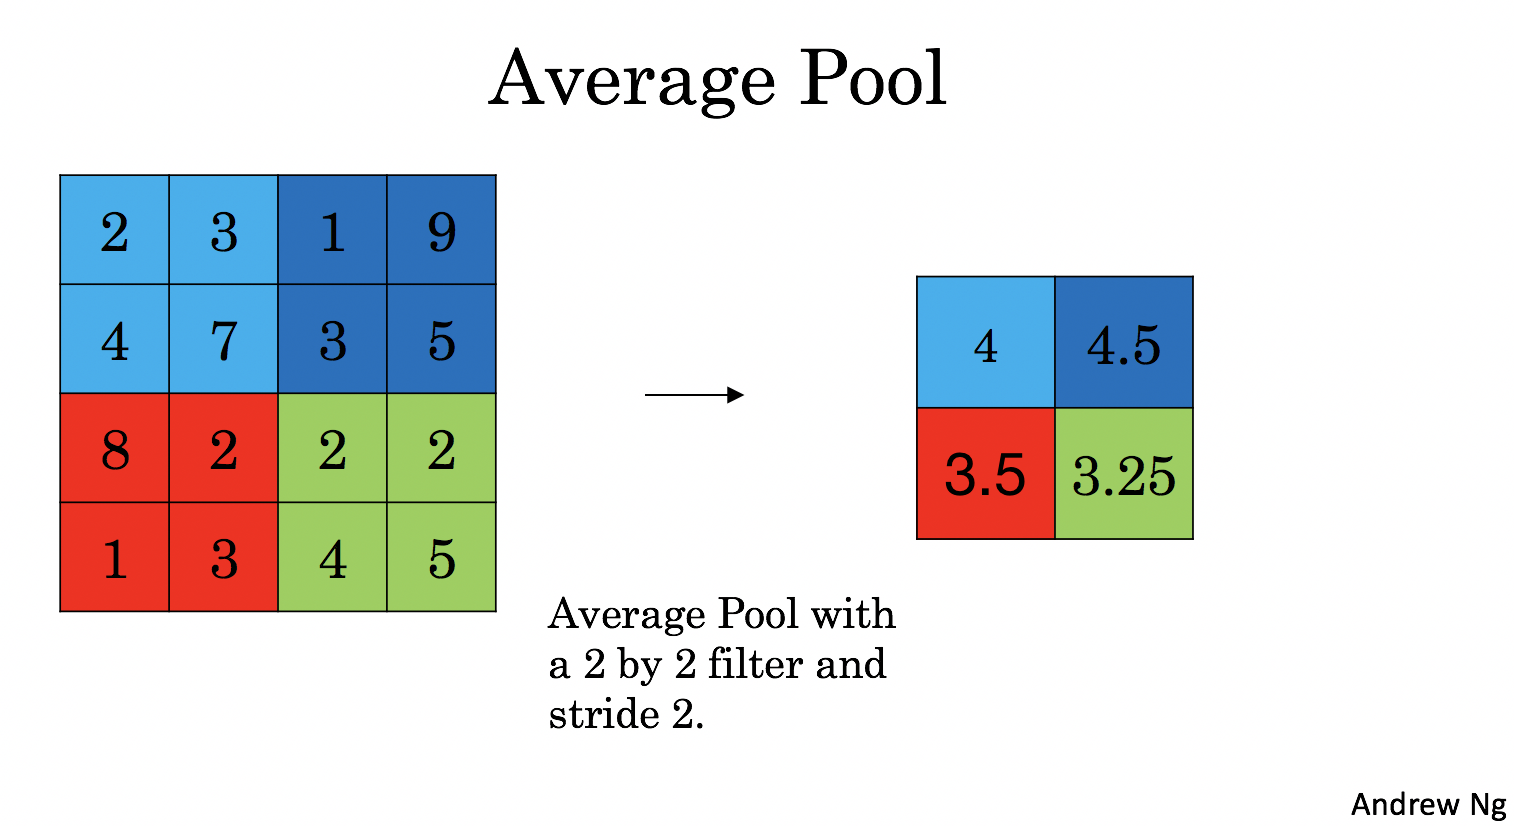
- These pooling layers have no parameters for backpropagation to train. However, they have hyperparameters such as the window size f. This specifies the height and width of the fxf window we would compute a max or average over.

## 4.1 Forward Pooling
- We are going to implement MAX-POOL and AVG-POOL in the same function.
- Implement the forward pass of the pooling layer.
- As there's no padding, the formula binding the output shape of the pooling to the input shape is :
    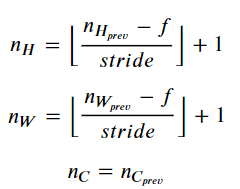

In [14]:
# GRADED FUNCTION: pool_forward

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    
    # Retrieve dimensions from the input shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # Retrieve hyperparameters from "hparameters"
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define the dimensions of the output
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Initialize output matrix A
    A = np.zeros((m, n_H, n_W, n_C))         
    
    for i in range(m):                         # loop over the training examples
        for h in range(n_H):                     # loop on the vertical axis of the output volume
            # Find the vertical start and end of the current "slice" 
            vert_start = h*stride
            vert_end = vert_start + f
            
            for w in range(n_W):                 # loop on the horizontal axis of the output volume
                # Find the vertical start and end of the current "slice" 
                horiz_start = w*stride
                horiz_end = horiz_start + f
                
                for c in range (n_C):            # loop over the channels of the output volume
                    
                    # Use the corners to define the current slice on the ith training example of A_prev, channel c.
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    # Compute the pooling operation on the slice. 
                    # Use an if statement to differentiate the modes. 
                    # Use np.max and np.mean.
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    
    # Store the input and hparameters in "cache" for pool_backward()
    cache = (A_prev, hparameters)
    
    return A, cache

In [15]:
# Case 1: stride of 1
print("CASE 1:\n")
np.random.seed(1)
A_prev_case_1 = np.random.randn(2, 5, 5, 3)
hparameters_case_1 = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])
A, cache = pool_forward(A_prev_case_1, hparameters_case_1, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1, 1] =\n", A[1, 1])

# Case 2: stride of 2
print("\n\033[0mCASE 2:\n")
np.random.seed(1)
A_prev_case_2 = np.random.randn(2, 5, 5, 3)
hparameters_case_2 = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "max")
print("mode = max")
print("A.shape = " + str(A.shape))
print("A[0] =\n", A[0])
print()

A, cache = pool_forward(A_prev_case_2, hparameters_case_2, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A[1] =\n", A[1])

CASE 1:

mode = max
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[1.96710175 0.84616065 1.27375593]
 [1.96710175 0.84616065 1.23616403]
 [1.62765075 1.12141771 1.2245077 ]]
mode = average
A.shape = (2, 3, 3, 3)
A[1, 1] =
 [[ 0.44497696 -0.00261695 -0.31040307]
 [ 0.50811474 -0.23493734 -0.23961183]
 [ 0.11872677  0.17255229 -0.22112197]]

CASE 2:

mode = max
A.shape = (2, 2, 2, 3)
A[0] =
 [[[1.74481176 0.90159072 1.65980218]
  [1.74481176 1.6924546  1.65980218]]

 [[1.13162939 1.51981682 2.18557541]
  [1.13162939 1.6924546  2.18557541]]]

mode = average
A.shape = (2, 2, 2, 3)
A[1] =
 [[[-0.17313416  0.32377198 -0.34317572]
  [ 0.02030094  0.14141479 -0.01231585]]

 [[ 0.42944926  0.08446996 -0.27290905]
  [ 0.15077452  0.28911175  0.00123239]]]


### Note
- A convolution extracts features from an input image by taking the dot product b/w the input data and a 3D array of weights (the filter).
- The 2D output of the convolution is called the feature map.
- A convolution layer is where the filter slides over the image and computes the dot product.
    - This transforms the input volume into an output volume of different size.
- Zero padding helps keep more information at the image borders and is helpful for building deeper networks, because we can build a CONV layer without shrinking the height and width of the volumes.
- Pooling layer gradually reduces the height and width of the input by sliding a 2D window over each specified region, then summarizing the features in that region.

# 5. Backpropagation in Convolutional Neural Network
- In modern deep learning framework, we only have to implement the forward pass, and the framework takes care of the backward pass, so most deep learning engineers don't need to bother with details of the backward pass. The backward pass for convolutional network is complicated.
- We implemented a simple (fully connected) neural network, we used backpropagation to compute the derivatives with respect to the cost to update the parameters. Similarly, in convolutional neural networks we can calculate the derivatives with respect to the cost in order to update the parameters. 

## 5.1 Convolutional Layer backward pass
### 5.1.1 Computing dA
- This is the formula to computing dA with respect to the cost for a certain filter Wc, and a given training example :
    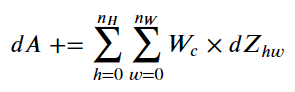
    - Where Wc is a filter and dZ(hw) is a sclar corresponding to the gradient cost with respective to the output of the conv layer Z at the hth row and with column (corresponding to the dot product taken at the ith stride left and jth stride down). Note that at each time we multiply the same filter Wc by a different dZ when updating dA. We do so mainly because when computing the forward propagation, each filter is dotted and summed by a different a_slice. Therefore when computing the backprop for dA, we are just adding the gradients of all the a_slices.
- 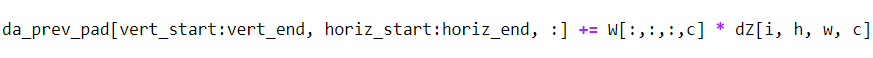
### 5.1.2 Computing dW:
- This is the formula for computing dWc (dWc is the derivative of one filter) with respect to the loss :
    - 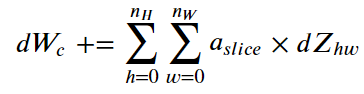
    - Where a(slice) corresponds to the slice which was ued to generate th activation Z(ij). Hence, this ends up giving the gradient for W with respect to that slice. Since it is the same W, we will just add up all such gradients to get dW.
- 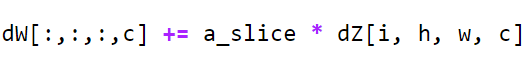
### 5.1.3 Computing db
- This is the formula for computing db with respective tot he cost for a certian filter Wc
    - 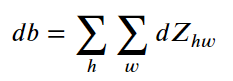
- 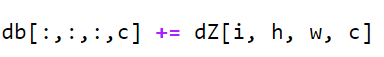